In [96]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import e,pow

In [97]:
class PowerStation:
    def __init__(self, StationName, OvernightCost,
                        FuelCost, LifeOfPlant, DiscountRate) -> None:
        self.stName = StationName
        self.OC = OvernightCost
        # M --> k hr --> yr
        self.fuel = round(FuelCost * 8.76,2)
        self.T = LifeOfPlant
        self.r = DiscountRate

        # From Fixed cost formular 
        # FC = (r * OC) / (1-1/(1+r)^T)
        self.FC = (self.r * self.OC)/(1- pow(e,(-1*(self.r*self.T))))

        # Variable cost calculated from fuel cost
        # VC = Fuel cost
        self.VC = self.fuel

        # Calculate flag
        self.isCalculated = False
        # Using memolization technique for reduced time complexity
        self._memo = {}

    def calculateARR(self,capacityFactor : float) -> float:
        # Calcuate ARR by using formular ARR = fixed cost + capacity factor * variable cost
        self._memo[capacityFactor] = self.FC + capacityFactor*self.VC

        # Set the stop iteration flag when CF = 1.0
        if capacityFactor >= 1.0: 
            self.isCalculated = True

        # Store calculated value as hash map for later use
        return self._memo[capacityFactor]

    def plot(self)-> None:
        # Plot store values
        if not self.isCalculated:
            raise ValueError("Please complete the itteration with calculateARR first")

        plt.plot(*zip(*sorted(self._memo.items())),label = self.stName)


    def __str__(self)-> str:
        return f"Station name : {self.stName}{chr(10)}Overnight Cost : {self.OC}{chr(10)}Fuel Cost : {self.fuel}{chr(10)}Life of plant : {self.T}{chr(10)}Discount rate : {self.r}"



In [98]:
# Get stations parameter from the csv file
filename = "new.csv"
stations = pd.read_csv(filename).to_dict('records')

# Check for CSV compatibility
for station in stations:
    header = ['StationName', 'OvernightCost', 'FuelCost', 'LifeOfPlant', 'DiscountRate']
    # Check CSV header
    if not list(station.keys()) == header:
        mismatch = [i for i, (a, b) in enumerate(zip(list(station.keys()), header)) if a != b]
        for mis in mismatch: print(f"Your CSV file are missing : {header[mis]}")
        raise ValueError("Given CSV file is not compatible")

    # Check each value data types  
    for value in header[1:]:
        if (type(station[value]) is str) :
            raise ValueError(f"{''.join([' '+ s if s.isupper()  else s for s in value]).lstrip()} should be a number")


# Create an PowerStation object from the parameter
stations = [PowerStation(**station) for station in stations]

In [99]:
# CSV viewer
pd.read_csv(filename)

,StationName,OvernightCost,FuelCost,LifeOfPlant,DiscountRate
0,Gas,432.33,51.4,10,0.2
1,Coal,1097.30,18.3,30,0.2
2,Combine Cycle,613.60,32.5,20,0.2


Screening Curve
Cheapest to run when CF < 0.151 : Gas  : 1322.76 hr
Cheapest to run when CF < 0.764 : Coal  : 6692.64 hr
Cheapest to run when CF > 0.764 : Combine Cycle : 6692.64 hr


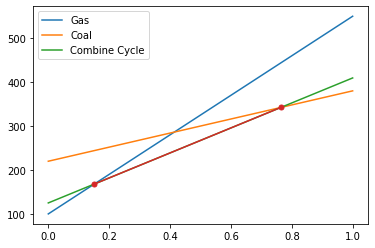

In [100]:
# Create linear space for numerical calculation
step_size = 1e-5
CF = np.arange(0,1.0+step_size,step_size).round(5).tolist()

# Initialize space for intersetion point
intersectionx ,intersectiony = [],[]
pointPrev = -1

# Iterate capacity factor value from 0 to 1.0 
for cf in CF:
    results = []
    # Loop through every station
    for station in stations:
        results.append(station.calculateARR(capacityFactor= cf))

    # Find the lowest prices generators
    point = min(range(len(results)),key=results.__getitem__)

    # If current generator no longer the cheapest -> Intersection point occur
    if point != pointPrev:
        if cf != 0.0:
            intersectionx.append(cf)
            intersectiony.append(min(results))
        
    pointPrev = point

else:
    # Show the result
    print("Screening Curve")
    if not intersectionx:
        print(f"Cheapest to run when CF < {1.0} : {stations[point].stName}  : {8760} hr" )


for idx, x in enumerate(intersectionx):
    print(f"Cheapest to run when CF < {round(x,3)} : {stations[idx].stName}  : {round(round(x,3)*8760,2)} hr" )
else:
    try:
        print(f"Cheapest to run when CF > {round(intersectionx[-1],3)} : {stations[-1].stName} : {round(round(intersectionx[-1],3)*8760,2)} hr" )
    except IndexError:
        pass 

# Show the plot
for station in stations : station.plot()
plt.plot(intersectionx,intersectiony,marker = "o", markersize=5)
plt.legend()
plt.show()

